# ITMAL - BREAKING THE CURSE OF DIMENSIONALITY

**Feature extraction and dimensionality reduction**

There are 3 assignments for J2 in this notebook.

_This notebook contains some of the sample code from chapter 8._

# Linear feature extraction by projection
Example: Build a 3D dataset and project it to 2D using PCA:

In [327]:
#build dataset
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

First let's look at how PCA is done:

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [273]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
#First and second principal components:
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [274]:
#Make a diagonal matrix of the singular values
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [275]:
#Test if we can 'recompose' X_centered from U, S, Vt
print(np.allclose(X_centered, U.dot(S).dot(Vt)))
#or
np.allclose(X_centered, np.matmul(np.matmul(U,S),Vt))

True


True

In [276]:
#Project X_centered onto plane of first and second principal components
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [277]:
X2D_using_svd = X2D

In [278]:
#check if the eig method gives the same singular values
eig_vals, eig_vecs = np.linalg.eig(np.matmul(X_centered,X_centered.T))

print(np.sqrt(eig_vals)[0:3])
print(s)

[6.77645005+0.j 2.82403671+0.j 0.78116597+0.j]
[6.77645005 2.82403671 0.78116597]


## PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [279]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [280]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [281]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [282]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [283]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [284]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [285]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [286]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [287]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [288]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [289]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio:

In [290]:
pca.explained_variance_ratio_


array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [291]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [292]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Let's plot the corresponding figures:

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [293]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [294]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

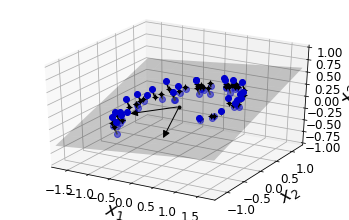

In [295]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

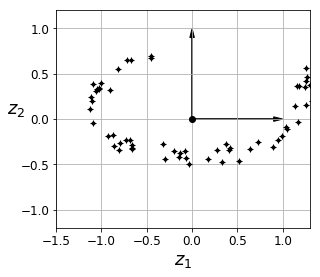

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


# MNIST PCA compression

By retaining less of the variance in the data, PCA can be used for data compression, and the compressed data can be used for training instead of the full data, which intuitively means faster processing, and in some cases also better performance.

In [1]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)


In [298]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [4]:
pca = PCA(0.95) #retain 95% variance

X_reduced = pca.fit_transform(X_train) #compress

#the number of components vs. the number of original features gives you an idea about compression ratio
print(pca.n_components_) 

X_recovered = pca.inverse_transform(X_reduced) #decompress

154


In [17]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed then Decompressed')

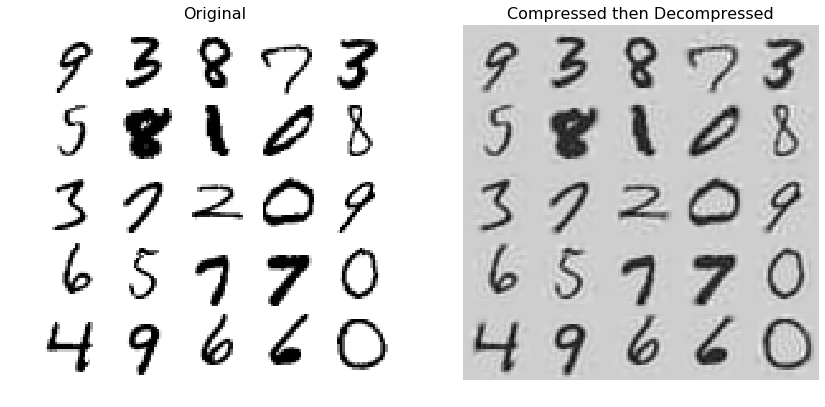

In [301]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed then Decompressed", fontsize=16)


Now let's see if we can speed up training significantly by training on compressed data.

Here is your baseline:

In [305]:
from sklearn.linear_model import LogisticRegression
import time

logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter = 1000, multi_class = 'multinomial')

time_start = time.time()
logisticRegr.fit(X_train, y_train)
print('logisticRegr done! Time elapsed: {} seconds'.format(time.time()-time_start))

logisticRegr.score(X_test, y_test)

logisticRegr done! Time elapsed: 98.81128001213074 seconds


C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9129142857142857

## ASSIGNMENT "speed up by compression" for J2:

See how much you can speed up the above while retaining similar performance, by training on compressed data. (Don't forget to transform your test data too). 

In [ ]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

In [2]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(0.95) # maintrain 95% variance

X_train_reduced = pca.fit_transform(X_train) #compress train data
X_test_reduced = pca.transform(X_test) #compress test data

In [13]:
from sklearn.linear_model import LogisticRegression
import time

logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter = 1000, multi_class = 'multinomial')

time_start = time.time()
logisticRegr.fit(X_train_reduced, y_train)
print('logisticRegr done! Time elapsed: {} seconds'.format(time.time()-time_start))

logisticRegr.score(X_test_reduced, y_test)

logisticRegr done! Time elapsed: 48.779114723205566 seconds


C:\Users\Bjarke Hansen\AppData\Local\conda\conda\envs\itmal\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9203428571428571

## A cautionary tale - PCA does not always improve things:

In [307]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [308]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [309]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.50s


In [310]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9450285714285714

In [311]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [312]:
rnd_clf2 = RandomForestClassifier(random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [313]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 8.73s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in chapter 8, dimensionality reduction does not always lead to faster training time; it depends on the dataset, the model and the training algorithm. 

In [314]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8910285714285714

It is not uncommon for performance to drop slightly when reducing dimensionality, because we might lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help; it slowed down training and reduced performance. 

# MNIST compression for noise reduction

Now that we have seen how PCA can be used for compression and training, we move on to see how PCA compression can be used to reduce noise in data. Obviously compression reduces the size of the data, but if the data is noisy it is also possible to improve the data quality by keeping even fewer PCA components.

## ASSIGNMENT "noise reduction" for J2:

Add some noise to MNIST (done below already), then compare a classifier trained and tested on:

Case 1: The noisy data.

Case 2: A PCA reduced version of the noisy data (remember to transform your test data too).

Can you find a reduced number of components that boosts performance? Different classifiers may handle noise more or less well by themselves. I tested with the SGDClassifier.


Text(0.5, 1.0, 'Noisy')

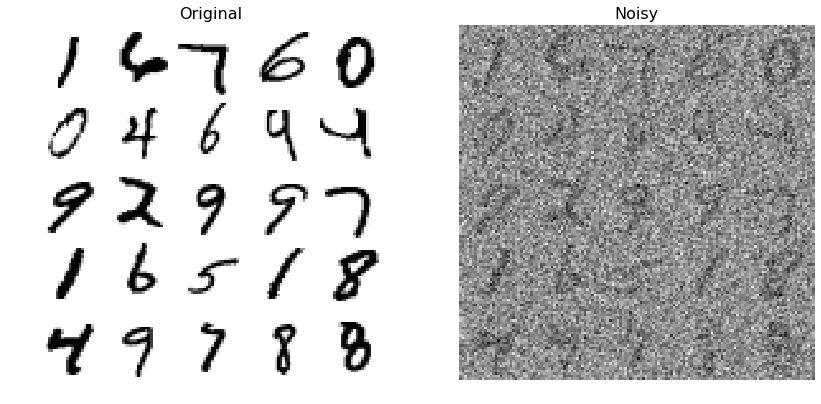

In [20]:
#generate noisy data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib

np.random.seed(42)
X_train_noisy = np.random.normal(X_train, 200)
X_test_noisy = np.random.normal(X_test, 200)

plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_train_noisy[::2100])
plt.title("Noisy", fontsize=16)

Text(0.5, 1.0, 'Improved by Compressed')

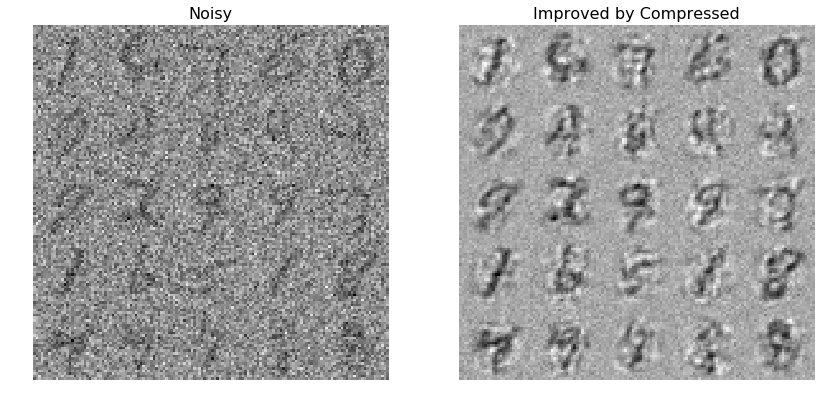

In [21]:
#test data improvement by compression
pca = PCA(n_components=0.2)
X_reduced = pca.fit_transform(X_train_noisy)
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train_noisy[::2100])
plt.title("Noisy", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Improved by Compressed", fontsize=16)

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model = SGDClassifier(random_state=46, max_iter=1000, tol=1e-3)

model.fit(X_train_noisy, y_train)
y_pred = model.predict(X_test_noisy)

accuracy_score(y_test, y_pred)

0.6205142857142857

In [28]:
model.fit(X_reduced, y_train)

X_test_reduced = pca.transform(X_test_noisy)
y_pred = model.predict(X_test_reduced)

accuracy_score(y_test, y_pred)

0.7072571428571428

# Manifold learning (non-linear feature extraction)
Example: First we make a Swiss roll dataset:

In [29]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

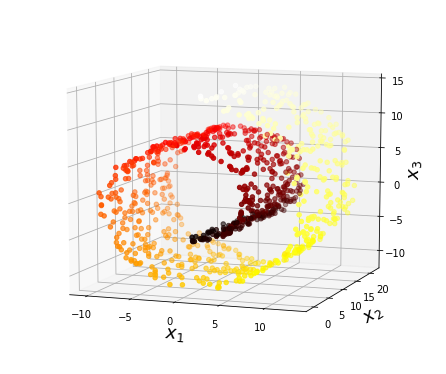

In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d,Axes3D 

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Let's compare the simple projection of the roll with the actual unrolled manifold (that we would like to learn):

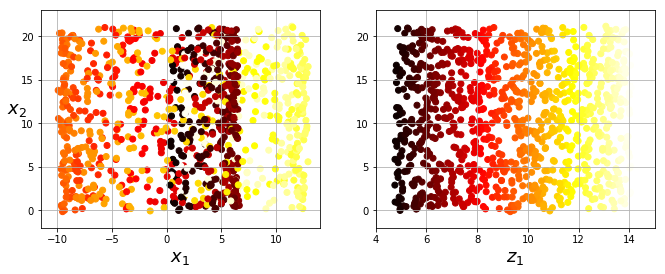

In [31]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

# Manifold learning by Kernel PCA

In [32]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

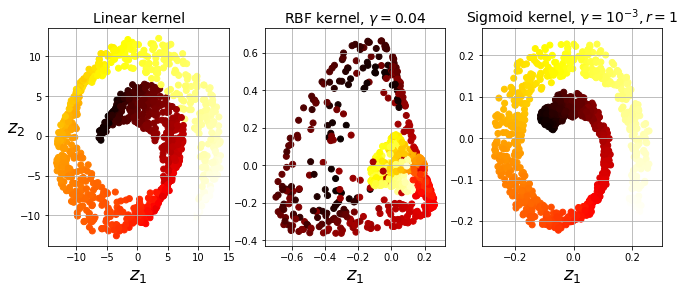

In [33]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Manifold learning by LLE

In [34]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

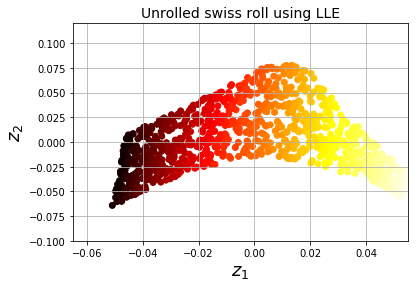

In [35]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# Manifold learning by MDS, Isomap and t-SNE

In [36]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [37]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

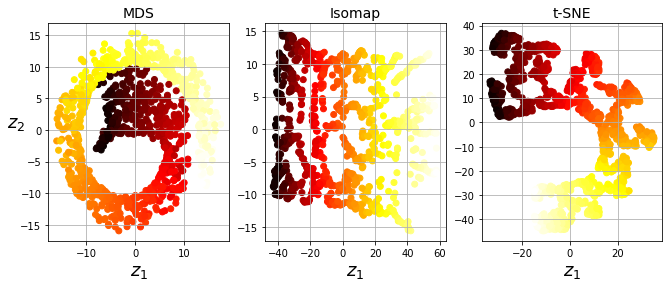

In [39]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# PCA versus t-SNE data visualization 

From the above it seems t-SNE performs very well, which might be expected since it also takes a long time.

Let's try using it to visualize the MNIST data, and compare against a PCA visualization:

Let's start with PCA. We will also time how long it takes:

In [40]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))


PCA took 1.6s.


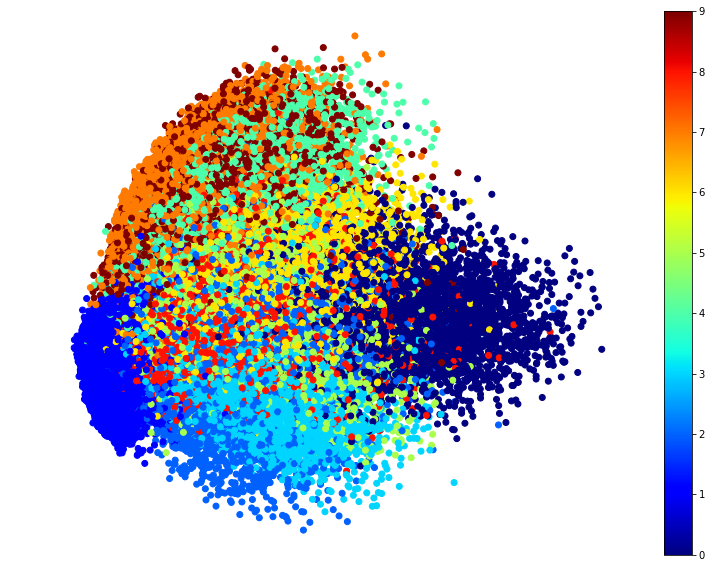

In [41]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

PCA is pretty fast, but although we do see a few clusters, there's way too much overlap. Let's try t-SNE:

t-SNE took 4451.2s.


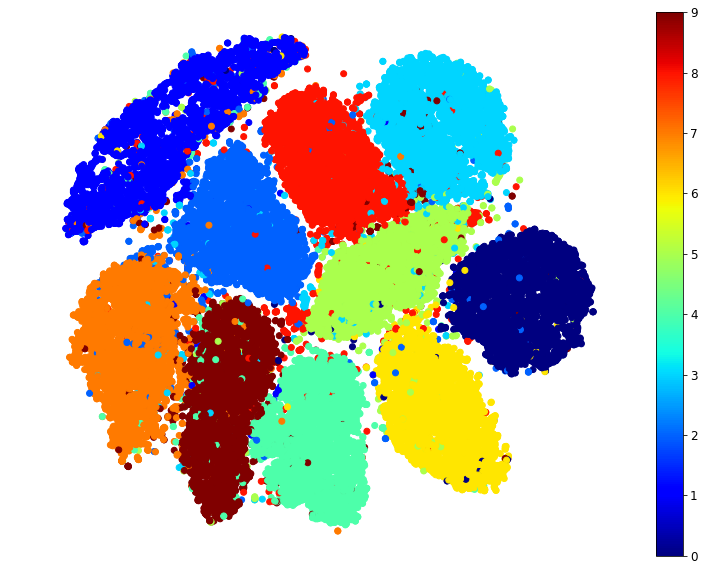

In [326]:
#OBS DON'T RUN THIS! LOOK HOW LONG IT TAKES..

from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Omg, that's slow. Let's see if a bit of PCA can speed it up:

In [42]:
from sklearn.pipeline import Pipeline
import time

pca_tsne = Pipeline([
    ("pca", PCA(n_components=20, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_train)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))


PCA+t-SNE took 1109.0s.


Yes, PCA gave us a good speedup.

Let's try to visualize:

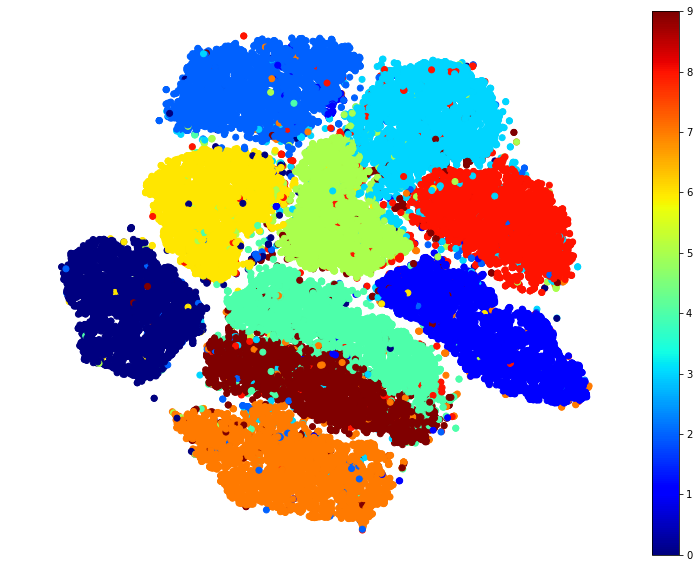

In [43]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

## ASSIGNMENT "PCA -> t-SNE features" for J2

From the above visualizations it seems reasonable that "PCA -> t-SNE" will perform much better than PCA alone 
as feature extraction by compression as input to a classifier (and be faster than t-SNE alone too).

Try if you can train and test with "PCA -> t-SNE" components (like we did earlier with PCA components). If not, explain why. 

In [45]:
t0 = time.time()
X_pca_tsne_reduced_test = pca_tsne.transform(X_test)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))

AttributeError: 'TSNE' object has no attribute 'transform'

Problemet er at t-sne ikke har en transform funktion. 